In [40]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

from keijzer_exogan import *

# Set random seem for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

#%matplotlib inline
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"} # Make sure the axis background of plots is white, this is usefull for the black theme in JupyterLab
#sns.set()

Random Seed:  999


In [41]:
torch.cuda.device_count()

4

In [42]:
# Root directory for dataset
dataroot = "/datc/opschaler/brian/celeba_complete"

# Number of workers for dataloader
workers = 0 # 0 when to_vram is enabled

# Batch size during training
batch_size = 1 # 2**11
print('Batch size: ', batch_size)

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 32

# Number of channels in the training images. For color images this is 3
nc = 1

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 32

# Size of feature maps in discriminator
ndf = 32

# Number of training epochs
num_epochs = 1 

# Learning rate for optimizers
lr = 2e-4
lr_G = 2e-4

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
selected_gpus = [1,2,3]
ngpu = len(selected_gpus)

Batch size:  1


## Mark the below cell as code to use the celeba dataset

## Mark the below cell as code to use the ExoGAN dataset

In [43]:
pwd

'/home/16011015/notebooks/SRON-DCGAN/notebooks'

In [44]:
##### Creating custom Dataset classes
path = '/datb/16011015/ExoGAN_data/selection//' #notice how you dont put the last folder in here...
images = np.load(path+'first_chunks_25_percent_images.npy')

shuffle = True

if shuffle:
    np.random.shuffle(images) # shuffles the images

images = images[:1] # select the first image, lateron this has to change to is load a 'selected' image to inpaint (instead of working from this excisting dataset)
print('Number of images: ', len(images))

dataset = numpy_dataset(data=images, to_vram=True) # to_vram pins it to all GPU's
#dataset = numpy_dataset(data=images, to_vram=True, transform=transforms.Compose([transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])) # to_vram pins it to all GPU's

# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers, pin_memory=False)

Number of images:  1


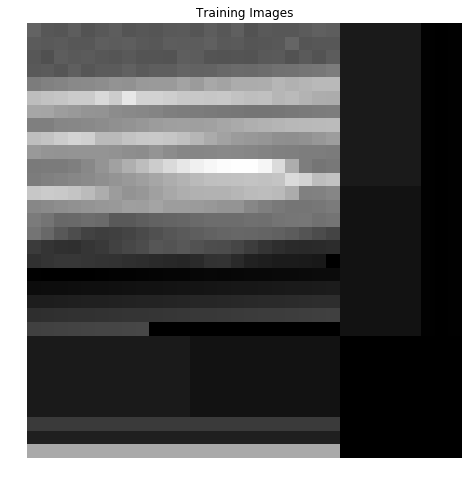

In [45]:
# Decide which device we want to run on
# Seems to be the main devive, e.g. cuda:0 wont work when only gpu [2,3] are selected... is [2,3] then do cuda:2
device = torch.device("cuda:"+str(selected_gpus[0]) if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [46]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [47]:
# Generator Code

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu

        """
        where (in_channels, out_channels, 
        kernel_size, stride=1, padding=0, output_padding=0, groups=1, bias=True, dilation=1)
        """
        self.main = nn.Sequential(
            
            #1
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            
            #4
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            nn.Dropout2d(0.5),
            
            #7
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            nn.Dropout2d(0.5),
            
            #10
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf*1, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf*1),
            nn.ReLU(True),
            
            # Go from 1x64x64 to 1x32x32
            nn.Conv2d(ngf, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf*1),
            nn.ReLU(True),
                        #10
            # state size. (ngf*2) x 16 x 16
            #nn.ConvTranspose2d( ngf * 2, ngf*1, 4, 2, 1, bias=False),
            #nn.BatchNorm2d(ngf*1),
            #nn.ReLU(True),
            
            #13
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d(ngf*1, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

In [48]:
# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, device_ids=selected_gpus, output_device=device) # select only gpu 0, 2, 3

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netG.apply(weights_init)

# Print the model
print(netG)

DataParallel(
  (module): Generator(
    (main): Sequential(
      (0): ConvTranspose2d(100, 256, kernel_size=(4, 4), stride=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace)
      (3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace)
      (6): Dropout2d(p=0.5)
      (7): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (9): ReLU(inplace)
      (10): Dropout2d(p=0.5)
      (11): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (12): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (13): ReLU(inplace)
      (14): Conv2d(32, 32, kerne

In [49]:
# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netG.apply(weights_init)

# Print the model
print(netG)

DataParallel(
  (module): Generator(
    (main): Sequential(
      (0): ConvTranspose2d(100, 256, kernel_size=(4, 4), stride=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace)
      (3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace)
      (6): Dropout2d(p=0.5)
      (7): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (9): ReLU(inplace)
      (10): Dropout2d(p=0.5)
      (11): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (12): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (13): ReLU(inplace)
      (14): Conv2d(32, 32, kerne

In [50]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 1, 4, 2, 1, bias=False),
            #nn.BatchNorm2d(ndf * 1),
            nn.LeakyReLU(0.2, inplace=True),
            
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 1, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 1, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [51]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    print('netD to cuda')
    netD = nn.DataParallel(netD, device_ids=selected_gpus, output_device=device) # select only gpu 0, 2, 3

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)

netD to cuda
DataParallel(
  (module): Discriminator(
    (main): Sequential(
      (0): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): LeakyReLU(negative_slope=0.2, inplace)
      (2): Conv2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (3): LeakyReLU(negative_slope=0.2, inplace)
      (4): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): LeakyReLU(negative_slope=0.2, inplace)
      (7): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (9): LeakyReLU(negative_slope=0.2, inplace)
      (10): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (11): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True

In [69]:
from torchsummary import summary
summary(netD, (1,1,32))

RuntimeError: cuDNN error: CUDNN_STATUS_BAD_PARAM

In [52]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1
fake_label = 0

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999)) # should be sgd
optimizerG = optim.Adam(netG.parameters(), lr=lr_G, betas=(beta1, 0.999))

In [53]:
import time as t

# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []

In [54]:
train_D = True
train_G = True

In [55]:
from IPython.display import clear_output

In [56]:
# Load saved weights
netG.load_state_dict(torch.load('netG_state_dict')) #net.module..load_... for parallel model , net.load_... for single gpu model
netD.load_state_dict(torch.load('netD_state_dict'))

In [61]:
from torchsummary import summary
summary(netG, (100,1,1))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 256, 4, 4]         409,600
   ConvTranspose2d-2            [-1, 256, 4, 4]         409,600
       BatchNorm2d-3            [-1, 256, 4, 4]             512
       BatchNorm2d-4            [-1, 256, 4, 4]             512
              ReLU-5            [-1, 256, 4, 4]               0
   ConvTranspose2d-6            [-1, 128, 8, 8]         524,288
              ReLU-7            [-1, 256, 4, 4]               0
   ConvTranspose2d-8            [-1, 128, 8, 8]         524,288
       BatchNorm2d-9            [-1, 128, 8, 8]             256
             ReLU-10            [-1, 128, 8, 8]               0
      BatchNorm2d-11            [-1, 128, 8, 8]             256
        Dropout2d-12            [-1, 128, 8, 8]               0
             ReLU-13            [-1, 128, 8, 8]               0
  ConvTranspose2d-14           [-1, 64,

In [64]:
netD.parameters

<bound method Module.parameters of DataParallel(
  (module): Discriminator(
    (main): Sequential(
      (0): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): LeakyReLU(negative_slope=0.2, inplace)
      (2): Conv2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (3): LeakyReLU(negative_slope=0.2, inplace)
      (4): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): LeakyReLU(negative_slope=0.2, inplace)
      (7): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (9): LeakyReLU(negative_slope=0.2, inplace)
      (10): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (11): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, tr

In [63]:
summary(netD, (100,1,1))

RuntimeError: Given groups=1, weight of size [32, 1, 4, 4], expected input[1, 100, 1, 1] to have 1 channels, but got 100 channels instead

# Inpainting
TODO: Implement the following

The corrupted image $y$ is mapped to the closest $z$ in the latent representation space, this mapping is denoted as $\hat{z}$.
    
$\hat{z} = \operatorname{arg\,min}_z \{ \mathcal{L}_c(z |y, M) + \mathcal{L}_p (z) \}$

where

$\mathcal{L}_c(z |y, M) = || M \bigodot G(z) - M \bigodot y||_1 = || M \bigodot (G(z)-y) ||_1 $

with $c$ being contextual loss and $M$ being a binary mask with the same size as $y$,

$\mathcal{L}_p (z) = \lambda \operatorname{log}(1-D(G(z)))$

with $p$ being perceptual loss and $D$ being the discriminator.

Once $G(\hat{z})$ is generated, the final solution $\hat{x}$ is calculated as

$\hat{x} = \operatorname{arg\, min}_x ||\nabla x - \nabla G(\hat{z}) ||^2_2$  

(substitute $x_i = y_i$ for $M_i = 1$).

-----

$|| ... ||$ is done by `torch.norm()`.  
$... \bigodot ...$ is done by `torch.mul()`.  

In [58]:
# (re)define variables (for clarity)

G = netG
D = netD
z = torch.randn(1, nz, 1, 1, requires_grad=True, device=device)

z.shape

torch.Size([1, 100, 1, 1])

In [59]:
n_iters = 1 # number of iters to do for inpainting

data.shape:  torch.Size([1, 1, 32, 32])
image.shape:  torch.Size([1, 1, 32, 32])
mask.shape torch.Size([1, 1, 32, 32])
image_generated_inpainted.shape :  torch.Size([1, 1, 32, 32])


ValueError: Expected more than 1 value per channel when training, got input size torch.Size([1, 256, 1, 1])

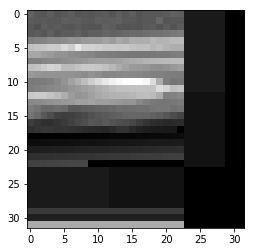

In [60]:
for epoch in range(num_epochs): # epochs
    for i, data in enumerate(dataloader, 0): # batches per epoch
        real_cpu = data.to(device)
        b_size = real_cpu.size(0) # this is one ofc, it's one image we're trying to inpaint
        
        print("data.shape: ", data.shape)
        image = data.to(device) # select the image (Channel, Height, Width), this is the original unmasked input image
        print("image.shape: ", image.shape)
        
        """Mask the images manually, for testing pruposes"""
        mask = torch.ones(size=image.shape).to(device) # create mask with 1's in the shape of image
        print("mask.shape", mask.shape)
        
        # use a random 'easy' mask
        mask[:, 5:15, 5:15] = 0
        
        masked_image = torch.mul(image, mask).to(device) #image bigodot mask
        
        #plt.imshow(masked_image.cpu()[0], cmap='gray') # plot the masked image
        
        opt = optim.Adam([z], lr=lr)
        
        # what's v and m?
        v = torch.tensor(0, dtype=torch.float32, device=device)
        m = torch.tensor(0, dtype=torch.float32, device=device)
        
        
        """Start the inpainting process"""
        for iteration in range(n_iters):
            if z.grad is not None:
                z_hat.grad.data.zero_()
            
            G.zero_grad()
            D.zero_grad()
            
            
            image_generated = G(z) # generated image G(z)
            image_generated_masked = torch.mul(image_generated, mask) # G(z) bigodot M
            image_generated_inpainted = torch.mul(image_generated, (1-mask))+masked_image
            
            print("image_generated_inpainted.shape : ",image_generated_inpainted.shape)
            
            t = image_generated_inpainted.detach().cpu()[0, 0, :, :]
            
            # TODO: why does this already look real?
            plt.imshow(t, cmap='gray') # plot the masked image 
            
            """Calculate losses"""
            loss_context = torch.norm(masked_image-image_generated_masked, p=1) #what's p=1?
            discriminator_output = netD(real_cpu)
            print(discriminator_output)